In [1]:
import os
import sys
import random
import time
import shutil
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential

from shutil import copyfile
from os import getcwd

import matplotlib as mpimg
import matplotlib.pyplot as plt

SETUP DIRECTORY STRUCTURE FOR TRAINING AND TESTING

In [2]:
def create_and_clear_dir_structure():
    try:
        if(os.path.isdir('Images/dandelion_v_other')):
            print('Directory dandelion_v_other found. Clearing out for next build.')
            shutil.rmtree('Images/dandelion_v_other/')
        
        os.mkdir('Images/dandelion_v_other/')
        os.mkdir('Images/dandelion_v_other/training')
        os.mkdir('Images/dandelion_v_other/testing')
        os.mkdir('Images/dandelion_v_other/training/dandelion')
        os.mkdir('Images/dandelion_v_other/testing/dandelion')
        os.mkdir('Images/dandelion_v_other/training/other')
        os.mkdir('Images/dandelion_v_other/testing/other')
    except OSError as e:
        print(f"OS DIR ERR: {e}")
        pass

create_and_clear_dir_structure()

Directory dandelion_v_other found. Clearing out for next build.


FUNCTION TO PROPERLY SPLIT UP OUR TRAIN/TEST IMAGES ACCORDING TO OUR SPLIT-SIZE RATIO. USUALLY .9/.1

In [3]:
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
    img_list = os.listdir(SOURCE)
    random.shuffle(img_list)
    length_of_list = len(img_list)
    length_of_training_list = int(length_of_list*SPLIT_SIZE)
    length_of_test_list = length_of_list - length_of_training_list
    train_list = img_list[:length_of_training_list]
    test_list = img_list[length_of_training_list:]

    print(f"TOTAL size:{length_of_list}")
    print(f"TRAIN size:{length_of_training_list}")
    print(f"TEST size:{length_of_test_list}")

    for file in train_list:
        full_img_path = SOURCE+file
        #print(f"TRAIN: {full_img_path}")
        if(os.path.getsize(full_img_path) < 0): #double check no 0 length image files
            img_list.remove(file)
            print(f"Found 0 length image file: {file}")
            print(f"File has been removed.")
        else:
            copyfile(full_img_path,TRAINING+file)

    for file in test_list:
        full_img_path = SOURCE + file
        #print(f"TEST: {full_img_path}")
        if (os.path.getsize(full_img_path) < 0):  # double check no 0 length image files
            img_list.remove(file)
            print(f"Found 0 length image file: {file}")
            print(f"File has been removed.")
        else:
            copyfile(full_img_path, TESTING + file)

            
DANDELION_SOURCE_DIR   = "Images/dandelion/"
OTHER_SOURCE_DIR       = "Images/other/"
TRAINING_DANDELION_DIR = "Images/dandelion_v_other/training/dandelion/"
TESTING_DANDELION_DIR  = "Images/dandelion_v_other/testing/dandelion/"
TRAINING_OTHER_DIR     = "Images/dandelion_v_other/training/other/"
TESTING_OTHER_DIR      = "Images/dandelion_v_other/testing/other/"


split_ratio = 0.9
split_data(DANDELION_SOURCE_DIR,TRAINING_DANDELION_DIR,TESTING_DANDELION_DIR,split_ratio)
split_data(OTHER_SOURCE_DIR,TRAINING_OTHER_DIR,TESTING_OTHER_DIR,split_ratio)

len_of_training_len = len(os.listdir('Images/dandelion_v_other/training/dandelion/')) + len(os.listdir('Images/dandelion_v_other/training/other/'))

print(len(os.listdir('Images/dandelion_v_other/training/dandelion/')))
print(len(os.listdir('Images/dandelion_v_other/training/other/')))
print(len(os.listdir('Images/dandelion_v_other/testing/dandelion/')))
print(len(os.listdir('Images/dandelion_v_other/testing/other/')))


TOTAL size:635
TRAIN size:571
TEST size:64
TOTAL size:627
TRAIN size:564
TEST size:63
571
564
64
63


LOAD PRE-TRAINED RESNET MODEL AS BASE

In [4]:
def base_resnet_model():
    base_model = Sequential()
    base_model.add(ResNet101V2(include_top = False, weights="imagenet", input_shape=(300,300, 3)))
    base_model.add(tf.keras.layers.GlobalAveragePooling2D())
    base_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    base_model.layers[0].trainable = False
    
    base_model.compile(optimizer=RMSprop(lr=1e-05),loss='binary_crossentropy',metrics=['accuracy'])
    print(f"Base summary: {base_model.summary()}")
    return base_model

In [5]:
def create_full_model(base_model):
    model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(optimizer=RMSprop(lr=1e-05),loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

BUILD MODEL

In [6]:
def create_model():
    model = tf.keras.models.Sequential([
        #we'll use 150x150 size and 3 color model
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #Flatten the results fo feed into DNN
        tf.keras.layers.Flatten(),
        #pass into 512 neuron hidden layer
        tf.keras.layers.Dense(512,activation='relu'),
        #Single output neuron...its a dandelion or not
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    return model

TRAIN MODEL: Including ImageGenerator so we can just hand off images via flow_from_directory method

In [7]:
def run_training(model):
    TRAINING_DIR = 'Images/dandelion_v_other/training'
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    #train w/batch size of 10
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(300,300))

    VALIDATION_DIR = 'Images/dandelion_v_other/testing'
    validation_datagen = ImageDataGenerator( rescale= 1./255)


    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                  batch_size=20,
                                                                  class_mode='binary',
                                                                  target_size=(300,300))

    checkpoint_path = "training_checkpoints/cp.ckpt" #one day we'll have millions and need to save our spot(s) in training ;)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    history = model.fit(train_generator,
                                  epochs=8,
                                  verbose=1,
                                  steps_per_epoch=20,
                                  validation_data = validation_generator,
                                  callbacks=[cp_callback])

    return history

REVIEW VIA PLOTS

In [8]:
def plot_history(history):
    #-----------------------------------------------
    # Get list of results on training and test data
    # for each epoch
    #-----------------------------------------------
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss    = history.history['loss']
    val_loss= history.history['val_loss']

    epochs = range(len(acc))

    #-----------------------------------------------
    #Plot train/validation accuracy
    #-----------------------------------------------
    plt.plot(epochs,acc,'r',label="Training Accuracy")
    plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()
    #-----------------------------------------------
    #Plot train/validation loss
    #-----------------------------------------------
    plt.plot(epochs,loss,'g',label="Training Loss")
    plt.plot(epochs,val_loss,'y',label="Validation Loss")
    plt.title('Training and validation loss')
    plt.legend()

Build and see what we get!


In [9]:
#model = create_model()
base_model = base_resnet_model()

#model = create_full_model(base_model)
time_start = round(time.time())
history = run_training(base_model)
time_end = round(time.time())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 10, 10, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 42,628,609
Trainable params: 2,049
Non-trainable params: 42,626,560
_________________________________________________________________
Base summary: None
Found 1135 images belonging to 2 classes.
Found 127 images belonging to 2 classes.
Epoch 1/8
20/20 [==============================] - ETA: 0s - loss: 0.7746 - accuracy: 0.5050
Epoch 00001: saving model to training_checkpoints/cp.ckpt
20/20 [==============================] - 163s 8s/step - loss: 0.7746 - accuracy: 0.5050 - val_loss: 0.6784 - val_accu

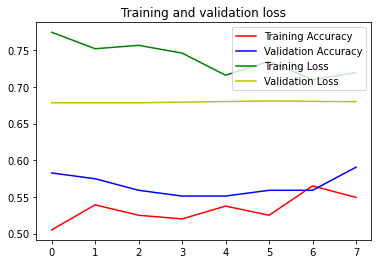

In [10]:
plot_history(history)

In [11]:
import datetime
import numpy as np

last_completed_training = datetime.datetime.now()
last_completed_accuracy = history.history['accuracy']
last_completed_loss =  history.history['loss']


acc      = np.array(history.history['accuracy']).mean()
val_acc  = np.array(history.history['val_accuracy']).mean()
loss     = np.array(history.history['loss']).mean()
val_loss = np.array(history.history['val_loss']).mean()

last_date_time_of_completed_training = datetime.datetime.now().strftime("%c")
length_of_time_for_training = time_end - time_start

STORE SOME DATA WE MAY LOOK INTO
-last run accuracy number
-last run loss number
-last length-of-time for training 
-last date/time training completed
-last total number of images processed
-time per epoch


In [12]:
import os

fp = open(f"{os.getcwd()}/metrics/metrics.csv","w")
fp.write("Last_Accuracy;Last_Loss;Validation_Loss;Length_of_Training;Last_Training_Finish;Total_Images\n")
data_string = f"{acc};{loss};{val_loss};{length_of_time_for_training};{last_date_time_of_completed_training};{len_of_training_len}\n"
fp.write(data_string)
fp.close()

In [13]:
import numpy as np
def model_quality_save(acc,model,threshold=0.50):
    if(acc > threshold):
        print(f"Model achieved {acc}% accuracy!\nSaving dandy_model.h5 for use.")
        model.save('saved_models/dandy_model_resnet_latest.h5')
    else:
        #send message that model was not good with acc/loss/val_acc/val_loss
        print(f"Model only made it to {acc}. Not saving. ")
        pass

print(acc)
model_quality_save(acc,base_model)



0.5332634374499321
Model achieved 0.5332634374499321% accuracy!
Saving dandy_model.h5 for use.
